# AI_Individualprojekt
## «Effiziente Bildverarbeitung und Speicheroptimierung für semantische Segmentierung»

#####  W.MDSE_VSMCL05.H2481: Artificial Intelligence
Liridona Cerkini - 
Rotkreuz, 10. Januar 2025

### Intro 
Die Verarbeitung von Bildern in neuronalen Netzen ist oft herausfordernd, da hohe Auflösungen zu Memory-Errors führen können. In der Vorstudie der Bachelorarbeit wurde deutlich, dass es schwierig ist, Originalbildgrössen beizubehalten, ohne Speicherprobleme zu verursachen. Gleichzeitig beeinflussen Anpassungsschritte wie Resizing oder die Zerlegung in Batches die Qualität der Segmentierungsergebnisse.

Das Ziel dieses Projekts ist es, ein tieferes Verständnis für diese Problematik zu entwickeln. Es soll analysiert werden, wie sich gewisse Vorverarbeitungsmethoden auf die Segmentierungsqualität auswirken um ausreichend aussagekräftige Ergebnisse für die Berechnung der IoU-Statistik zwischen den Ground-Truth-Masken und den Modellvorhersagen zu liefern. Durch diese Analyse soll ein besseres Verständnis für die Balance zwischen Speicherbedarf, Bildgrösse und Modellgenauigkeit geschaffen werden..

### Ziele
- Analyse Auswirkungen Kompression/Auflösungsreduktion auf Modellgenauigkeit (IoU)
- Validierung einfache vs. komplexere Task  
### Daten
- 2'975 Bilder aus dem Cityscape-Datensatz
- Einfache Task: segmentiert mit Deeplabv3
- Komplexere Task: segmentiert mit OneFormer (Thesis Bezug)
### Vorgehen
- Speicheranalyse: Vergleich Speicherbedarfs Modelle 
- Bildkompression: Vergleich Kompressionsmethoden
- Streaming: Test von Stream-Reading-Ansätzen für grosse Datasets (Thesis Bezug)
- Qualität: Bewertung IoU für komprimierte vs. unkomprimierte Bilder & einfache vs. komplexere Task (ausgewählte Klassen)


### Verwendete Datensätze:
- Cordts u. a., „The Cityscapes Dataset for Semantic Urban Scene Understanding“. 
(Quelle: http://arxiv.org/abs/1604.01685)

### Weitere Quellen:

- DeeplabV3: https://arxiv.org/pdf/1706.05587
- OneFormer: http://arxiv.org/abs/2211.06220
- HuggingFace: https://huggingface.co/

### Bibliotheken importieren

In [1]:
#Clone OneFormer Repo
!rm -rf OneFormer/
!git clone https://github.com/SHI-Labs/OneFormer-Colab.git
! mv OneFormer-Colab OneFormer

Cloning into 'OneFormer-Colab'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 141 (delta 6), reused 6 (delta 6), pack-reused 128 (from 1)
Receiving objects: 100% (141/141), 6.73 MiB | 34.47 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="oneformer")

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7bve1_ap
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7bve1_ap
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done


<Logger oneformer (DEBUG)>

In [3]:
!pip install transformers
import torch
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
!pip install datasets
from datasets import load_dataset
from PIL import Image
import requests

from tqdm import tqdm
from transformers import AutoProcessor, OneFormerForUniversalSegmentation

import numpy as np
import os
from __future__ import print_function
import json

from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### Datenset importieren

Zunächst wird der Direktimport des Datasets verwendet, bei dem das gesamte Dataset auf einmal in den Arbeitsspeicher geladen wird, was bei kleinen bis mittelgrossen Datasets effizient ist, jedoch bei grösseren Datasets zu hohen Speicheranforderungen führen kann.

Später wird auch der Streaming-Ansatz untersucht. Hierbei wird das Dataset schrittweise bei Bedarf geladen, ohne den gesamten Datensatz auf einmal in den Speicher zu laden. Dieser Ansatz wird ebenfalls über Hugging Face ermöglicht, indem der Parameter streaming=True verwendet wird (d.h. load_dataset("Chris1/cityscapes_segmentation", streaming=True))

In [4]:
ds = load_dataset("liuch37/controlnet-cityscapes")

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'seg', 'caption'],
        num_rows: 2975
    })
})

In [6]:
# Subsets erstellen
ds_subset = ds['train'].select(range(24)).remove_columns(['seg', 'caption'])
ds_subset_seg = ds['train'].select(range(24)).remove_columns(['image', 'caption'])


In [7]:
ds_subset

Dataset({
    features: ['image'],
    num_rows: 24
})

In [8]:
ds_subset_seg

Dataset({
    features: ['seg'],
    num_rows: 24
})

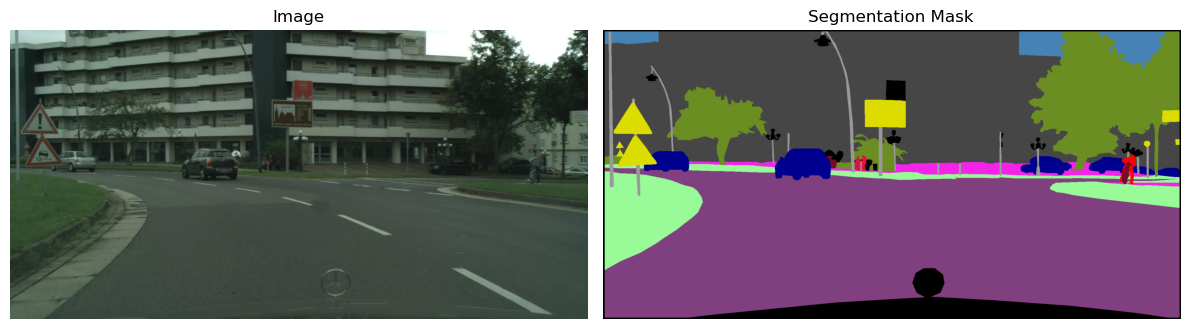

In [9]:
# Greife auf das erste Beispiel im Trainingsdatensatz zu
image = ds_subset[0]['image'] # Das Bild
segmentation = ds_subset_seg[0]['seg']  # Die Segmentierungsmaske

# Bilder nebeneinander anzeigen
plt.figure(figsize=(12, 6))

# Bild
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")

# Segmentierungsmaske
plt.subplot(1, 2, 2)
plt.imshow(segmentation, cmap="jet")  # "jet" hilft, die Masken klarer zu machen
plt.title("Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

### Vergleich des Speicherbedarfs der beiden Modelle 

In [10]:
# Prüfen ob CUDA (GPU) vergügbar ist
if torch.cuda.is_available():
    # Get GPU details
    device = torch.device("cuda")
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    # Freien Speicher berechnen
    free_memory = total_memory - allocated_memory
    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")
    print(f"Cached GPU Memory: {cached_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Please check your GPU setup.")

Total GPU Memory: 14.54 GB
Allocated GPU Memory: 0.00 GB
Free GPU Memory: 14.54 GB
Cached GPU Memory: 0.00 GB


### Model laden 

In [ ]:
#Deeplabv3 aus Torchvision laden
deeplabv3 = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device).eval()

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#OneFormer über Transformers laden
from transformers import AutoProcessor, OneFormerForUniversalSegmentation

processor = AutoProcessor.from_pretrained("shi-labs/oneformer_cityscapes_swin_large")
oneformer = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_cityscapes_swin_large")

In [ ]:
# Speicherbedarf der beiden Modelle berechnen 
deeplabv3_memory = sum(p.numel() for p in deeplabv3.parameters())
oneformer_memory = sum(p.numel() for p in oneformer.parameters())

print(f"Deeplabv3 Model Memory: {deeplabv3_memory / (1024 ** 2):.2f} MB")
print(f"OneFormer Model Memory: {oneformer_memory / (1024 ** 2):.2f} MB")

In [ ]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get GPU details
    device = torch.device("cuda")
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)

    # Calculate free memory
    free_memory = total_memory - allocated_memory
    print(f"Total GPU Memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated GPU Memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Free GPU Memory: {free_memory / (1024 ** 3):.2f} GB")
    print(f"Cached GPU Memory: {cached_memory / (1024 ** 3):.2f} GB")
else:
    print("CUDA is not available. Please check your GPU setup.")

Vor dem Laden der Modelle war der gesamte GPU-Speicher 14.54 GB, wobei noch kein Speicher belegt war. Nach dem Laden der Modelle (Deeplabv3 mit 58.17 MB und OneFormer mit 208.65 MB) werden insgesamt 0.23 GB GPU-Speicher genutzt, während noch 14.31 GB frei sind. Der zusätzliche Speicherbedarf resultiert aus PyTorch-Overhead und Caching. Der Cached Memory zeigt an, dass PyTorch Speicher für zukünftige Operationen vorab reserviert hat. Insgesamt bleibt genügend GPU-Speicher für weitere Aufgaben verfügbar, was die Effizienz der Modelle im Vergleich zur Gesamtmenge an GPU-Speicher unterstreicht.

Der geringere Speicherbedarf von Deeplabv3 im Vergleich zu OneFormer lässt sich durch die einfachere Architektur von Deeplabv3 erklären. Deeplabv3 basiert auf einer weniger komplexen Architektur als OneFormer und verwendet weniger Parameter. Dies liegt daran, dass Deeplabv3 ursprünglich für Segmentierungsaufgaben entwickelt wurde, während OneFormer fortschrittlichere Technologien wie Transformer-Modelle nutzt, die mehr Parameter und eine komplexere Struktur erfordern, um universelle Segmentierungsaufgaben zu bewältigen.

### Ground Truth Segmentation des Cityscape Datasets

Zuerst wird die 'Ground Truth' untersucht, um die Farbe der erkannten Objekte zu bestimmen.
Im Rahmen dieser Untersuchung konzentrieren und evaluieren wird schlussendlich folgende 3 Labels:

- Personen
- Autos
- Fahrräder

Hierfür wird ein Bild herangezogen, welche alle drei gennanten Objekte beinhaltet, nämlich "zurich_000045_000019_leftImg8bit.png"

In [ ]:
# Ausgewählte Bild anzeigen
Image.open('z_zurich/zurich_000045_000019_leftImg8bit.png')

In [ ]:
Image.open('z_maske_zurich/zurich_000045_000019_gtFine_color.png')

In [ ]:
# Laden des Originalbildes
original_image_path = "z_maske_zurich/zurich_000045_000019_gtFine_color.png"
original_image = Image.open(original_image_path)

# Funktion zum Erstellen eines Bildes mit nur einer bestimmten Farbe
def create_color_image(image, color):
    # Erstellen einer leeren Kopie des Originalbildes
    color_image = Image.new("RGB", image.size, color=(0, 0, 0))
    # Ersetzen der Pixelwerte mit der gewünschten Farbe
    for x in range(image.width):
        for y in range(image.height):
            pixel_color = image.getpixel((x, y))
            if pixel_color == color:
                color_image.putpixel((x, y), color)
    return color_image

# Extrahieren der einzigartigen Farben aus dem Originalbild
unique_colors = set(original_image.getdata())

# Erstellen und Anzeigen eines neuen Bildes für jede einzigartige Farbe
num_cols = 2
num_rows = len(unique_colors) // num_cols + (1 if len(unique_colors) % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for idx, color in enumerate(unique_colors):
    row = idx // num_cols
    col = idx % num_cols
    color_image = create_color_image(original_image, color)
    axes[row, col].imshow(color_image)
    axes[row, col].set_title(f"Farbe: {color}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

#### Bewertung Ground Truth Segmentation
Nun wissen wir, welche Farbe welchem Objekt entspricht:

- Person = (220,20,60)
- Radfahrer* = (255,0,0)
- Auto = (0,0,142)
- Fahrrad = (119,11,32)

*Disclaimer: Ein auf dem COCO-Dataset vortrainiertes Modell klassifiziert sowohl eine Person als auch einen Radfahrer als "Person".

#### Suchen und Ersetzen

Wie wir bereits wissen, wird bei der Segmentierung eines Bildes mit einem Modell jedem Pixel eine Klasse zugewiesen.
Die Farbe, die wir in der Ground Truth identifiziert haben, werden nun durch die Klassennummer ersetzt.

In [ ]:
# Initialisieren eines leeren Dictionaries für die Masken
mask_dict = {}

#COCO Klassennummern Mapping
color_to_class_coco = {
    (220, 20, 60): 15,  # Person
    (255, 0, 0): 15,    # Radfahrer
    (119, 11, 32): 2,   # Fahrrad
    (0, 0, 142): 7,    # Auto
}

# Iteriere über alle Bilder im Subset
for idx, (image_sample, seg_sample) in tqdm(enumerate(zip(ds_subset, ds_subset_seg))):
    # Lade das Bild und die Ground Truth-Maske
    image = image_sample['image']
    ground_truth = seg_sample['seg']

    # Konvertiere das Bild in den Modus RGB für einfachen Zugriff auf die Farbwerte
    ground_truth_rgb = np.array(ground_truth.convert("RGB"))

    # Erstelle einen leeren Tensor, der die Ground Truth-Maske mit Klassenzuweisungen speichert
    replaced_mask_tensor = np.zeros(ground_truth_rgb.shape[:2], dtype=int)

    # Iteriere über jedes Pixel im Bild (durchlaufe Höhe und Breite)
    for i, j in np.ndindex(ground_truth_rgb.shape[:2]):
        pixel_color = ground_truth_rgb[i, j]  # Hol dir den RGB-Wert des Pixels
        pixel_color_tuple = tuple(pixel_color)
        if pixel_color_tuple in color_to_class_coco:
            # Wenn der Pixel-Farbwert im Mapping enthalten ist, ersetze ihn mit der Klassennummer
            replaced_mask_tensor[i, j] = color_to_class_coco[pixel_color_tuple]

    # Speichern des ersetzten Ground Truth-Tensors im Dictionary
    mask_dict[f"image_{idx}"] = replaced_mask_tensor

# Beispiel: Anzeige eines Eintrags aus dem Dictionary
for image_name, mask in mask_dict.items():
    print(f"Bildname: {image_name}, Maskenform: {mask.shape}")

##### Notes
349it [28:05:00],  4.42s/it / Update: 865it [1:13:00] ....Durchschnittlich 4.5-5.5 sec/Iteration.
Aufgrund dieser langen Ladezeit, ist Subset von 100 Bildern erstellt worden. Die Analyse wird zunächst darauf basieren.

Um sicherzustellen, dass das Mapping korrekt angewendet wurde, werden die eindeutigen Klassenwerte angezeigt:

In [ ]:
# Den ersten Schlüssel aus dem Dictionary erhalten
first_key = list(mask_dict.keys())[0]

# Die Form und Länge des Tensors im ersten Schlüssel berechnen
first_mask = mask_dict[first_key]
print(f"Erste Maske: {first_key}, Form: {first_mask.shape}")

# Liste für das Sammeln aller Werte initialisieren
all_values = []

# Alle Werte aus den Tensoren im Dictionary sammeln
for mask in mask_dict.values():
    all_values.extend(mask.flatten())  # Werte aus der Maske extrahieren und in die Liste einfügen

# Eindeutige Werte extrahieren
unique_values = np.unique(all_values)

# Eindeutige Werte anzeigen
print(f"Eindeutige Klassenwerte in den Masken: {unique_values}")

Für das 2. Modell (OneFormer):

In [ ]:
# Initialisieren eines zweiten leeren Dictionaries für die Masken
mask_dict2 = {}

# COCO Klassennummern Mapping für den zweiten Durchlauf
color_to_class_coco2 = {
    (220, 20, 60): 11,  # Person
    (255, 0, 0): 12,    # Radfahrer
    (119, 11, 32): 18,   # Fahrrad
    (0, 0, 142): 13,     # Auto
}

# Iteriere über alle Bilder im Subset für den zweiten Durchlauf
for idx, (image_sample, seg_sample) in tqdm(enumerate(zip(ds_subset, ds_subset_seg))):
    # Lade das Bild und die Ground Truth-Maske
    image = image_sample['image']
    ground_truth = seg_sample['seg']

    # Konvertiere das Bild in den Modus RGB für einfachen Zugriff auf die Farbwerte
    ground_truth_rgb2 = np.array(ground_truth.convert("RGB"))

    # Erstelle einen zweiten leeren Tensor, der die Ground Truth-Maske mit Klassenzuweisungen speichert
    replaced_mask_tensor2 = np.zeros(ground_truth_rgb2.shape[:2], dtype=int)

    # Iteriere über jedes Pixel im Bild (durchlaufe Höhe und Breite)
    for i2, j2 in np.ndindex(ground_truth_rgb2.shape[:2]):
        pixel_color2 = ground_truth_rgb2[i2, j2]  # Hol dir den RGB-Wert des Pixels
        pixel_color_tuple2 = tuple(pixel_color2)
        if pixel_color_tuple2 in color_to_class_coco2:
            # Wenn der Pixel-Farbwert im Mapping enthalten ist, ersetze ihn mit der Klassennummer
            replaced_mask_tensor2[i2, j2] = color_to_class_coco2[pixel_color_tuple2]

    # Speichern des ersetzten Ground Truth-Tensors im zweiten Dictionary
    mask_dict2[f"image_{idx}"] = replaced_mask_tensor2

# Beispiel: Anzeige eines Eintrags aus dem zweiten Dictionary
for image_name2, mask2 in mask_dict2.items():
    print(f"Bildname: {image_name2}, Maskenform: {mask2.shape}")


In [ ]:
# Den ersten Schlüssel aus dem zweiten Dictionary erhalten
first_key2 = list(mask_dict2.keys())[0]

# Die Form und Länge des Tensors im ersten Schlüssel des zweiten Dictionaries berechnen
first_mask2 = mask_dict2[first_key2]
print(f"Erste Maske (zweiter Durchlauf): {first_key2}, Form: {first_mask2.shape}")

# Liste für das Sammeln aller Werte im zweiten Durchlauf initialisieren
all_values2 = []

# Alle Werte aus den Tensoren im zweiten Dictionary sammeln
for mask2 in mask_dict2.values():
    all_values2.extend(mask2.flatten())  # Werte aus der Maske extrahieren und in die Liste einfügen

# Eindeutige Werte im zweiten Durchlauf extrahieren
unique_values2 = np.unique(all_values2)

# Eindeutige Werte im zweiten Durchlauf anzeigen
print(f"Eindeutige Klassenwerte in den Masken (zweiter Durchlauf): {unique_values2}")

Die definierten Klassen wurden übernommen. Wir machen weiter mit der eigentlichen Segmentierung.

### Semantische Segmentierung

Disclaimer: Beim Versuch, das Subset mit den Bildern in Originalgrösse zu segmentieren, trat ein CUDA Memory Error auf, da der GPU-Speicher überschritten wurde. Durch die Verkleinerung der Bilder auf 256x256 Pixel konnte die Segmentierung erfolgreich durchgeführt werden. Bei weiteren Überlegungen wurde festgestellt, dass die Berechnung der Gradienten deaktiviert werden kann. Da für die Vorhersage eines Bildes keine Gradienten benötigt werden, führt dies zu einer erheblichen Einsparung von GPU-Speicher und einer Reduzierung des Rechenaufwands. Mit dieser Anpassung konnte die Segmentierung auch für das Subset mit Originalgrösse erfolgreich durchgeführt werden. 
Angesichts der langen Laufzeit beim Segmentieren mit dem Modell OneFormer (ca. 300 Sekunden pro Iteration) wurde entschieden, den Vergleich mithilfe der Metrik auf eine reduzierte Bildanzahl von etwa 25 Bildern (Originalgrösse) zu beschränken. Dies ist zielgerichtet und hält den zeitlichen Rahmen ein.

#### mit dem Modell DeeplabV3

In [ ]:
# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [ ]:
def decode_segmap(image, nc=21):  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
# Function for segmenting an image
def segment_image(image):
    # Preprocessing and normalization
    preproc_img = preprocessing(image)
    normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
    normalized_inp.requires_grad = False  # Gradientenberechnung deaktivieren
    
    # Segmentation
    with torch.no_grad():  # Deaktiviert Gradientenberechnung
        out = deeplabv3(normalized_inp)['out']
    out_max = torch.argmax(out, dim=1, keepdim=True)
    
    # Convert segmentation to RGB
    rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
    
    return rgb

# Iterate over the image dataset
fig, axes = plt.subplots(6, 4, figsize=(20, 20))  # Grid für 24 Bilder (6x4)

for idx in tqdm(range(24), desc="Segmenting images"):  # Fortschrittsanzeige
    # Load the image from the dataset
    image = ds_subset[idx]['image']
    
    # Segment the image
    segmented_image = segment_image(image)
    
    # Display the segmented image
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(segmented_image)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Image {idx}")

# Remove empty subplots
for i in range(24, 6 * 4):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


In [ ]:
# Dictionary zur Speicherung der out_max-Tensoren für jedes Bild
out_max_deeplabv3 = {}

# Iteriere über die Bilder im Dataset (ds_subset[0:24]['image'])
for idx in tqdm(range(24), desc="Segmenting images"):  # Fortschrittsanzeige für die Iteration
    # Lade das Bild aus dem Dataset
    image = ds_subset[idx]['image']
    
    # Vorverarbeitung und Normalisierung
    preproc_img = preprocessing(image)
    normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
    normalized_inp.requires_grad = False  # Setze requires_grad auf False, da wir keine Gradienten benötigen
    
    # Segmentierung
    with torch.no_grad():  # Deaktiviert die Berechnung von Gradienten
        out = deeplabv3(normalized_inp)['out']
    out_max = torch.argmax(out, dim=1, keepdim=True)
    
    # Speichern des out_max-Tensors im Dictionary
    filename = f"image_{idx}"  # Erstelle einen eindeutigen Namen (z. B. image_0, image_1, ...)
    out_max_deeplabv3[filename] = out_max

# Konvertiere die Tensoren in 2-dimensionale Arrays
out_max_deeplabv3 = {key: value.squeeze().cpu().numpy() for key, value in out_max_deeplabv3.items()}


In [ ]:
# Den ersten Schlüssel aus dem Dictionary erhalten
first_key_out = next(iter(out_max_deeplabv3.keys()))

# Calculate the length of the tensor in the first key
num_values_out = out_max_deeplabv3[first_key_out].size

# Die Werte für den ersten Schlüssel ausgeben
print("Key:", first_key_out)
print("")
print("Values:", out_max_deeplabv3[first_key_out])
print("")
print("Number of elements in the first key:", num_values_out)

In [ ]:
# Liste für das Sammeln aller Werte initialisieren
all_values = []

# Alle Werte aus den Tensoren sammeln
for tensor in out_max_deeplabv3.values():
    all_values.extend(tensor.flatten().tolist())

# Eindeutige Werte extrahieren
unique_values = set(all_values)

# Eindeutige Werte anzeigen
print(unique_values)

#### Metriken

Für die Qualitätsbewertung wird **Intersection over Union (IoU)** verwendet:
- IoU berechnet das Verhältnis der Fläche der Schnittmenge zur Fläche der Vereinigung der Segmente.
- Damit quantifiziert IoU die Übereinstimmung zwischen vorhergesagten und tatsächlichen Segmenten.

##### DeeplabV3

In [ ]:
# Definiere die ausgewählten Klassen (z.B. Person, Radfahrer, Auto)
selected_classes = [2, 7, 15]

# Funktion zur Berechnung des IoU in Prozent für jede Klasse
def calculate_iou_percentage(pred_mask, true_mask, selected_classes):
    iou_dict = {}
    
    for class_id in selected_classes:
        # Binary mask für die aktuelle Klasse erstellen (True für die Klasse, False für den Rest)
        pred_class_mask = (pred_mask == class_id).astype(int)
        true_class_mask = (true_mask == class_id).astype(int)
        
        # Intersection und Union berechnen
        intersection = np.sum(pred_class_mask * true_class_mask)
        union = np.sum(pred_class_mask) + np.sum(true_class_mask) - intersection
        
        # IoU berechnen
        if union == 0:  # Vermeidung einer Division durch 0
            iou = 0
        else:
            iou = (intersection / union) * 100  # IoU in Prozent
        
        iou_dict[class_id] = iou
    
    return iou_dict

# Leeres Dictionary für IoU-Werte in Prozent
iou_results_percentage = {}

# Iteriere über alle 24 Bilder und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in %"):
    # Lade die Vorhersage (out_max) und Ground Truth-Maske aus den Dictionaries
    pred_mask = out_max_deeplabv3[f"image_{idx}"]  # Vorhersage
    true_mask = mask_dict[f"image_{idx}"]  # Ground Truth-Maske
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image = calculate_iou_percentage(pred_mask, true_mask, selected_classes)
    
    # Speichere die IoU-Ergebnisse in Prozent
    iou_results_percentage[f"image_{idx}"] = iou_for_image

# Beispiel-Ausgabe der IoU-Werte in Prozent für das erste Bild
for image_name, iou_values in iou_results_percentage.items():
    print(f"{image_name}: {iou_values}")


In [ ]:
# Leeres Dictionary für die gesammelten IoU-Werte
iou_per_class = {class_id: [] for class_id in selected_classes}

# Iteriere über alle 24 Bilder und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in %"):
    # Lade die Vorhersage (out_max) und Ground Truth-Maske aus den Dictionaries
    pred_mask = out_max_deeplabv3[f"image_{idx}"]  # Vorhersage
    true_mask = mask_dict[f"image_{idx}"]  # Ground Truth-Maske
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image = calculate_iou_percentage(pred_mask, true_mask, selected_classes)
    
    # Füge die IoU-Werte für jede Klasse zu den entsprechenden Listen hinzu, nur wenn der IoU > 0 ist
    for class_id, iou in iou_for_image.items():
        if iou > 0:  # Nur dann hinzufügen, wenn der IoU > 0 ist
            iou_per_class[class_id].append(iou)

# Berechne den Durchschnitt der IoU-Werte für jede Klasse (nur für nicht 0 IoU-Werte)
average_iou_per_class = {class_id: np.mean(iou_values) if iou_values else 0 for class_id, iou_values in iou_per_class.items()}

# Beispiel-Ausgabe der durchschnittlichen IoU-Werte für jede Klasse
for class_id, avg_iou in average_iou_per_class.items():
    print(f"Durchschnittlicher IoU für Klasse {class_id}: {avg_iou:.2f}%")


Gemäss den Benchmark-Ergebnissen auf Papers with Code erreicht DeepLabv3 auf dem Cityscapes-Datensatz eine mIoU von etwa 70 %. Daher erscheint das Resultat plausibel.

#### mit dem Modell OneFormer

In [ ]:
label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

In [ ]:
# OneFormer Model
# Funktion zum Laden, Segmentieren und Visualisieren eines Bildes
def segment_image_with_oneformer(image, processor, oneformer, label_colors):
    # Vorbereitung des Bildes für das Modell
    semantic_inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")
    
    # Forward-Pass durch das Modell
    with torch.no_grad():
        outputs = oneformer(**semantic_inputs)
    
    # Post-Processing der Ausgabe
    predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    
    # Dekodiere die Segmentierungs-IDs in ein RGB-Bild
    image_array = predicted_semantic_map.numpy()
    r = np.zeros_like(image_array).astype(np.uint8)
    g = np.zeros_like(image_array).astype(np.uint8)
    b = np.zeros_like(image_array).astype(np.uint8)

    # Farbzuordnung für jedes Label
    for l in range(len(label_colors)):
        idx = image_array == l
        r[idx] = label_colors[l][0]
        g[idx] = label_colors[l][1]
        b[idx] = label_colors[l][2]

    rgb_image = np.stack([r, g, b], axis=2)
    
    return rgb_image

In [ ]:
# OneFormer Model
# Funktion zum Laden, Segmentieren und Visualisieren eines Bildes
def segment_image_with_oneformer(image, processor, oneformer, label_colors):
    # Vorbereitung des Bildes für das Modell
    semantic_inputs = processor(images=image, task_inputs=["semantic"], return_tensors="pt")
    
    # Forward-Pass durch das Modell
    with torch.no_grad():
        outputs = oneformer(**semantic_inputs)
    
    # Post-Processing der Ausgabe
    predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    
    # Die Label-IDs (Segmentierungs-IDs) direkt aus dem Modell
    label_ids = predicted_semantic_map.numpy()
    
    # Dekodiere die Segmentierungs-IDs in ein RGB-Bild
    r = np.zeros_like(label_ids).astype(np.uint8)
    g = np.zeros_like(label_ids).astype(np.uint8)
    b = np.zeros_like(label_ids).astype(np.uint8)

    # Farbzuordnung für jedes Label
    for l in range(len(label_colors)):
        idx = label_ids == l
        r[idx] = label_colors[l][0]
        g[idx] = label_colors[l][1]
        b[idx] = label_colors[l][2]

    rgb_image = np.stack([r, g, b], axis=2)  # RGB-Bild erstellen
    
    return rgb_image, label_ids  # Rückgabe des RGB-Bildes und der Label-IDs


# Dictionary zur Speicherung der RGB-Bilder und Labels
out_max_oneformer = {}
out_label_ids = {}

# Iteriere über die Bilder im Dataset (ds_subset[0:24]['image'])
for idx in tqdm(range(24), desc="Segmenting images with OneFormer"):
    # Lade das Bild aus dem Dataset
    image = ds_subset[idx]['image']
    
    # Segmentiere das Bild und erhalte das RGB-Bild und die Label-IDs
    segmented_image, label_ids = segment_image_with_oneformer(image, processor, oneformer, label_colors)
    
    # Speichere die Ergebnisse in den Dictionaries
    filename = f"image_{idx}"  # Eindeutiger Dateiname
    out_max_oneformer[filename] = segmented_image  # RGB-Bild speichern
    out_label_ids[filename] = label_ids  # Label-IDs speichern
    
    # Speicher freigeben, um GPU-Speicher zu optimieren
    torch.cuda.empty_cache()

# Optional: Visualisierung des ersten segmentierten Bildes mit OneFormer
plt.figure(figsize=(6, 6))
plt.imshow(out_max_oneformer['image_0'])  # RGB-Bild anzeigen
plt.title("Segmented Image (OneFormer) - First Image")
plt.axis("off")
plt.show()

# Beispiel für die Labels eines Bildes
print("Labels für das erste Bild:")
print(out_label_ids['image_0'])


In [ ]:
# Funktion zur Visualisierung aller segmentierten Bilder und Labels
def display_all_segmentations(out_max_oneformer, out_label_ids, rows=6, cols=4, figsize=(20, 20)):
    num_images = len(out_max_oneformer)  # Anzahl der Bilder im Dictionary
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flach machen für leichtere Iteration

    for idx, (filename, rgb_image) in enumerate(out_max_oneformer.items()):
        if idx >= len(axes):  # Falls mehr Bilder als Platz im Grid
            print(f"Es gibt mehr Bilder ({num_images}), als im Grid ({rows}x{cols}) Platz haben!")
            break
        
        # Zeige das RGB-Bild
        axes[idx].imshow(rgb_image)
        axes[idx].set_title(f"{filename}")
        axes[idx].axis("off")

        # Optional: Labels drucken (debuggen)
        # print(f"Labels für {filename}:\n", out_label_ids[filename])
    
    # Deaktiviere die übrigen leeren Achsen
    for ax in axes[num_images:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Aufruf der Funktion zur Anzeige aller gespeicherten Segmentierungen
display_all_segmentations(out_max_oneformer, out_label_ids, rows=6, cols=4, figsize=(20, 20))


### Metriken

Für die Qualitätsbewertung wird **Intersection over Union (IoU)** verwendet:
- IoU berechnet das Verhältnis der Fläche der Schnittmenge zur Fläche der Vereinigung der Segmente.
- Damit quantifiziert IoU die Übereinstimmung zwischen vorhergesagten und tatsächlichen Segmenten.

##### OneFormer

In [ ]:
# Den ersten Schlüssel aus dem Dictionary erhalten
first_key_out2 = next(iter(out_max_oneformer.keys()))

# Calculate the length of the tensor in the first key
num_values_out2 = out_label_ids[first_key_out2].size

# Die Werte für den ersten Schlüssel ausgeben
print("Key:", first_key_out2)
print("")
print("Values:", out_label_ids[first_key_out2])
print("")
print("Number of elements in the first key:", num_values_out2)

In [ ]:
# Liste für das Sammeln aller Werte initialisieren
all_values2 = []

# Alle Werte aus den Tensoren sammeln
for tensor in out_label_ids.values():
    all_values2.extend(tensor.flatten().tolist())

# Eindeutige Werte extrahieren
unique_values2 = set(all_values2)

# Eindeutige Werte anzeigen
print(unique_values2)

In [ ]:
# Beispiel für das Laden einer Modellkonfiguration, falls das Modell Label-Namen enthält
model_config = oneformer.config  # Konfiguration des OneFormer-Modells

# Wenn der Konfigurationsspeicher die Label-Namen enthält, könnte dies so aussehen:
label_names_from_config = model_config.id2label  # Ein Dictionary mit Label-ID zu Label-Namen
print(label_names_from_config)


In [ ]:
# Definiere die ausgewählten Klassen 
selected_classes2 = [11, 12, 13, 18]

# Leeres Dictionary für IoU-Werte in Prozent
iou_results_percentage2 = {}

# Iteriere über alle 24 Bilder und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in %"):
    # Lade die Vorhersage (out_max) und Ground Truth-Maske aus den Dictionaries
    pred_mask2 = out_label_ids[f"image_{idx}"]  # Vorhersage
    true_mask2 = mask_dict2[f"image_{idx}"]  # Ground Truth-Maske
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image = calculate_iou_percentage(pred_mask2, true_mask2, selected_classes2)
    
    # Speichere die IoU-Ergebnisse in Prozent
    iou_results_percentage[f"image_{idx}"] = iou_for_image

# Beispiel-Ausgabe der IoU-Werte in Prozent für das erste Bild
for image_name, iou_values in iou_results_percentage.items():
    print(f"{image_name}: {iou_values}")


In [ ]:
# Leeres Dictionary für die gesammelten IoU-Werte
iou_per_class2 = {class_id: [] for class_id in selected_classes2}

# Iteriere über alle 24 Bilder und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in %"):
    # Lade die Vorhersage (out_max) und Ground Truth-Maske aus den Dictionaries
    pred_mask2 = out_label_ids[f"image_{idx}"]  # Vorhersage
    true_mask2 = mask_dict2[f"image_{idx}"]  # Ground Truth-Maske
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image2 = calculate_iou_percentage(pred_mask2, true_mask2, selected_classes2)
    
    # Füge die IoU-Werte für jede Klasse zu den entsprechenden Listen hinzu, nur wenn der IoU > 0 ist
    for class_id, iou in iou_for_image2.items():
        if iou > 0:  # Nur dann hinzufügen, wenn der IoU > 0 ist
            iou_per_class2[class_id].append(iou)

# Berechne den Durchschnitt der IoU-Werte für jede Klasse (nur für nicht 0 IoU-Werte)
average_iou_per_class2 = {class_id: np.mean(iou_values) if iou_values else 0 for class_id, iou_values in iou_per_class2.items()}

# Beispiel-Ausgabe der durchschnittlichen IoU-Werte für jede Klasse
for class_id, avg_iou in average_iou_per_class2.items():
    print(f"Durchschnittlicher IoU für Klasse {class_id}: {avg_iou:.2f}%")


Der pretrained OneFormer mit einem Swin-Large-Backbone erreicht laut Benchmarks auf dem Cityscapes-Validierungsdatensatz eine mittlere Intersection over Union (mIoU) von 83,0 % bei Single-Scale-Inferenz. Das Resultat scheint plausibel. Im Gegensatz zum Deeplabv3 kann der OneFormer auch unter Fahrrad und Fahrradfahrer unterscheiden.

### Bildkompression

**Patchify** ist eine Bildverarbeitungstechnik, bei der grosse Bilder in kleinere Abschnitte (Patches) zerlegt werden, um Speicher- oder Architekturgrenzen von Modellen wie neuronalen Netzwerken zu überwinden. Der grösste Nachteil bei der Bildsegmentierung liegt jedoch im Verlust globaler Kontextinformationen zwischen den Patches. Dadurch ist Patchify für Real-World-Segmentierungsaufgaben meist ungeeignet. Methoden, die das gesamte Bild analysieren, etwa durch Resizing oder Multiskalenansätze, gewährleisten bei realen Szenarien deutlich höhere Präzision und Zuverlässigkeit.

**Downsampling** oder **Resizing** reduziert die Bildauflösung, indem die Bildgrösse verringert wird, um Speicherbedarf und Verarbeitungszeit zu minimieren. Dies geht jedoch zulasten feiner Bilddetails und kann die Genauigkeit der Segmentierung beeinträchtigen. In der folgenden Analyse wird die Segmentierung auf um den Faktor 1/4 verkleinerten Bildern durchgeführt und mit den Ergebnissen auf den Originalbildern verglichen.

#### Resizing-Methode

In [ ]:
# Resizing-Funktion
def resize_image(image):
    width, height = image.size
    new_size = (width // 4, height // 4)
    return image.resize(new_size)

##### DeeplabV3 auf komprimierten Bildern

In [ ]:
# Dictionary zur Speicherung der segmentierten Bilder
out_max_deeplabv3_resized = {}

# Funktion zur Segmentierung eines resized Bildes
def segment_resized_image(image):
    # Resizing des Bildes
    resized_image = resize_image(image)
    
    # Preprocessing und Normalisierung
    preproc_img = preprocessing(resized_image)
    normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
    normalized_inp.requires_grad = False  # Gradientenberechnung deaktivieren
    
    # Segmentierung
    with torch.no_grad():  # Deaktiviert Gradientenberechnung
        out = deeplabv3(normalized_inp)['out']
    out_max = torch.argmax(out, dim=1, keepdim=True)
    
    # Konvertiere Segmentierung in RGB
    rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
    
    return rgb

# Fortschrittsanzeige für die Verarbeitung der Bilder
for idx in tqdm(range(24), desc="Segmenting resized images"):  # Fortschrittsbalken für die Schleife
    # Lade das resized Bild aus dem Dataset
    image = ds_subset[idx]['image']
    
    # Segmentiere das resized Bild
    segmented_image = segment_resized_image(image)
    
    # Speichern des segmentierten Bildes im Dictionary
    filename = f"resized_image_{idx}"  # Erstelle einen eindeutigen Dateinamen
    out_max_deeplabv3_resized[filename] = segmented_image  # Speichere das segmentierte Bild
    
    # Wenn es das erste Bild ist, zeige es an
    if idx == 0:  # Nur das erste Bild anzeigen
        plt.figure(figsize=(6, 6))
        plt.imshow(segmented_image)
        plt.title("Segmented Resized Image - First Image")
        plt.axis('off')
        plt.show()

##### OneFormer auf komprimierten Bildern

In [ ]:
# Dictionary zur Speicherung der RGB-Bilder und Labels für die resized Bilder
out_max_oneformer_resized = {}
out_label_ids_resized = {}

# Iteriere über die Bilder im Dataset (ds_subset[0:24]['image'])
for idx in tqdm(range(24), desc="Segmenting resized images with OneFormer"):
    # Lade das Bild aus dem Dataset
    image = ds_subset[idx]['image']
    
    # Resizing des Bildes
    resized_image = resize_image(image)
    
    # Segmentiere das resized Bild und erhalte das RGB-Bild und die Label-IDs
    segmented_image_resized, label_ids_resized = segment_image_with_oneformer(resized_image, processor, oneformer, label_colors)
    
    # Speichere die Ergebnisse in den Dictionaries
    filename = f"resized_image_{idx}"  # Eindeutiger Dateiname
    out_max_oneformer_resized[filename] = segmented_image_resized  # RGB-Bild speichern
    out_label_ids_resized[filename] = label_ids_resized  # Label-IDs speichern
    
    # Speicher freigeben, um GPU-Speicher zu optimieren
    torch.cuda.empty_cache()

# Optional: Visualisierung des ersten resized segmentierten Bildes mit OneFormer
plt.figure(figsize=(6, 6))
plt.imshow(out_max_oneformer_resized['resized_image_0'])  # RGB-Bild anzeigen
plt.title("Segmented Image (OneFormer) - First Resized Image")
plt.axis("off")
plt.show()

# Beispiel für die Labels eines resized Bildes
print("Labels für das erste resized Bild:")
print(out_label_ids_resized['resized_image_0'])


##### Bewertung IoU für komprimierte vs. unkomprimierte Bilder & einfache vs. komplexere Task

- Es wurde eine minime Verbesserung in der Geschwindigkeit festgestellt. Schade ist, dass die Verarbeitungszeit für resized Bilder mit dem OneFormer weiterhin etwa 300-350 Sekunden pro Iteration beträgt...
- DeeplabV3: über Orignalgrösse 24/24 [00:00:33] / über 4x vergkleinerte Bilder 24/24 [00:00:14]
- OneFormer: über Orignalgrösse 24/24 [02:25:22] / über 4x vergkleinerte Bilder 24/24 [02:18:14]
- 

##### Masken auf die selbe Dimension bringen

In [ ]:
# Initialisieren eines leeren Dictionaries für die Masken
mask_dict_resized = {}

# COCO Klassennummern Mapping
color_to_class_coco = {
    (220, 20, 60): 15,  # Person
    (255, 0, 0): 15,    # Radfahrer
    (119, 11, 32): 2,   # Fahrrad
    (0, 0, 142): 7,     # Auto
}

# Iteriere über alle Bilder im Subset
for idx, (image_sample, seg_sample) in tqdm(enumerate(zip(ds_subset, ds_subset_seg))):
    # Lade das Bild und die Ground Truth-Maske
    image = image_sample['image']
    ground_truth = seg_sample['seg']

    # Hole die Dimensionen des Bildes und berechne die neuen Abmessungen
    width, height = image.size
    new_width, new_height = width // 4, height // 4

    # Skaliere das Bild und die Ground Truth-Maske
    image_resized = image.resize((new_width, new_height))
    ground_truth_resized = ground_truth.resize((new_width, new_height))

    # Konvertiere das Bild in den Modus RGB für einfachen Zugriff auf die Farbwerte
    ground_truth_rgb = np.array(ground_truth_resized.convert("RGB"))

    # Erstelle einen leeren Tensor, der die Ground Truth-Maske mit Klassenzuweisungen speichert
    replaced_mask_tensor = np.zeros(ground_truth_rgb.shape[:2], dtype=int)

    # Iteriere über jedes Pixel im Bild (durchlaufe Höhe und Breite)
    for i, j in np.ndindex(ground_truth_rgb.shape[:2]):
        pixel_color = ground_truth_rgb[i, j]  # Hol dir den RGB-Wert des Pixels
        pixel_color_tuple = tuple(pixel_color)
        if pixel_color_tuple in color_to_class_coco:
            # Wenn der Pixel-Farbwert im Mapping enthalten ist, ersetze ihn mit der Klassennummer
            replaced_mask_tensor[i, j] = color_to_class_coco[pixel_color_tuple]

    # Speichern des ersetzten Ground Truth-Tensors im Dictionary
    mask_dict_resized[f"image_{idx}"] = replaced_mask_tensor

# Beispiel: Anzeige eines Eintrags aus dem Dictionary
for image_name, mask in mask_dict_resized.items():
    print(f"Bildname: {image_name}, Maskenform: {mask.shape}")


In [ ]:
# Initialisieren eines zweiten leeren Dictionaries für die Masken
mask_dict_resized2 = {}

# COCO Klassennummern Mapping für den zweiten Durchlauf
color_to_class_coco2 = {
    (220, 20, 60): 11,  # Person
    (255, 0, 0): 12,    # Radfahrer
    (119, 11, 32): 18,  # Fahrrad
    (0, 0, 142): 13,    # Auto
}

# Iteriere über alle Bilder im Subset für den zweiten Durchlauf
for idx, (image_sample, seg_sample) in tqdm(enumerate(zip(ds_subset, ds_subset_seg))):
    # Lade das Bild und die Ground Truth-Maske
    image = image_sample['image']
    ground_truth = seg_sample['seg']

    # Hole die Dimensionen des Bildes und berechne die neuen Abmessungen
    width, height = image.size
    new_width, new_height = width // 4, height // 4

    # Skaliere das Bild und die Ground Truth-Maske
    image_resized = image.resize((new_width, new_height))
    ground_truth_resized = ground_truth.resize((new_width, new_height))

    # Konvertiere das Bild in den Modus RGB für einfachen Zugriff auf die Farbwerte
    ground_truth_rgb2 = np.array(ground_truth_resized.convert("RGB"))

    # Erstelle einen zweiten leeren Tensor, der die Ground Truth-Maske mit Klassenzuweisungen speichert
    replaced_mask_tensor2 = np.zeros(ground_truth_rgb2.shape[:2], dtype=int)

    # Iteriere über jedes Pixel im Bild (durchlaufe Höhe und Breite)
    for i2, j2 in np.ndindex(ground_truth_rgb2.shape[:2]):
        pixel_color2 = ground_truth_rgb2[i2, j2]  # Hol dir den RGB-Wert des Pixels
        pixel_color_tuple2 = tuple(pixel_color2)
        if pixel_color_tuple2 in color_to_class_coco2:
            # Wenn der Pixel-Farbwert im Mapping enthalten ist, ersetze ihn mit der Klassennummer
            replaced_mask_tensor2[i2, j2] = color_to_class_coco2[pixel_color_tuple2]

    # Speichern des ersetzten Ground Truth-Tensors im zweiten Dictionary
    mask_dict_resized2[f"image_{idx}"] = replaced_mask_tensor2

# Beispiel: Anzeige eines Eintrags aus dem zweiten Dictionary
for image_name2, mask2 in mask_dict_resized2.items():
    print(f"Bildname: {image_name2}, Maskenform: {mask2.shape}")


##### DeeplabV3 (resized)

In [ ]:
# Leeres Dictionary für die gesammelten IoU-Werte für Deeplabv3 (resized)
iou_per_class_deeplabv3_resized = {class_id: [] for class_id in selected_classes}

# Iteriere über alle 24 resized segmentierten Bilder mit Deeplabv3 und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in % for resized images with Deeplabv3"):
    # Lade die Vorhersage (out_max) für das resized Bild und Ground Truth-Maske aus den Dictionaries
    pred_mask_deeplabv3_resized = out_max_deeplabv3_resized[f"resized_image_{idx}"]  # Vorhersage für resized Bild
    true_mask_deeplabv3_resized = mask_dict_resized[f"image_{idx}"]  # Ground Truth-Maske für das resized Bild
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image_deeplabv3_resized = calculate_iou_percentage(pred_mask_deeplabv3_resized, true_mask_deeplabv3_resized, selected_classes)
    
    # Füge die IoU-Werte für jede Klasse zu den entsprechenden Listen hinzu, nur wenn der IoU > 0 ist
    for class_id, iou in iou_for_image_deeplabv3_resized.items():
        if iou > 0:  # Nur dann hinzufügen, wenn der IoU > 0 ist
            iou_per_class_deeplabv3_resized[class_id].append(iou)

# Berechne den Durchschnitt der IoU-Werte für jede Klasse (nur für nicht 0 IoU-Werte)
average_iou_per_class_deeplabv3_resized = {class_id: np.mean(iou_values) if iou_values else 0 for class_id, iou_values in iou_per_class_deeplabv3_resized.items()}

# Beispiel-Ausgabe der durchschnittlichen IoU-Werte für jede Klasse
for class_id, avg_iou in average_iou_per_class_deeplabv3_resized.items():
    print(f"Durchschnittlicher IoU für Klasse {class_id} (resized Bilder, Deeplabv3): {avg_iou:.2f}%")

##### OneFormer (resized)

In [ ]:
# Leeres Dictionary für die gesammelten IoU-Werte für OneFormer (resized)
iou_per_class_oneformer_resized = {class_id: [] for class_id in selected_classes2}

# Iteriere über alle 24 resized segmentierten Bilder mit OneFormer und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in % for resized images with OneFormer"):
    # Lade die Vorhersage (out_max) für das resized Bild und Ground Truth-Maske aus den Dictionaries
    pred_mask_oneformer_resized = out_label_ids_resized[f"resized_image_{idx}"]  # Vorhersage für resized Bild
    true_mask_oneformer_resized = mask_dict_resized2[f"image_{idx}"]  # Ground Truth-Maske für das Originalbild
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image_oneformer_resized = calculate_iou_percentage(pred_mask_oneformer_resized, true_mask_oneformer_resized, selected_classes2)
    
    # Füge die IoU-Werte für jede Klasse zu den entsprechenden Listen hinzu, nur wenn der IoU > 0 ist
    for class_id, iou in iou_for_image_oneformer_resized.items():
        if iou > 0:  # Nur dann hinzufügen, wenn der IoU > 0 ist
            iou_per_class_oneformer_resized[class_id].append(iou)

# Berechne den Durchschnitt der IoU-Werte für jede Klasse (nur für nicht 0 IoU-Werte)
average_iou_per_class_oneformer_resized = {class_id: np.mean(iou_values) if iou_values else 0 for class_id, iou_values in iou_per_class_oneformer_resized.items()}

# Beispiel-Ausgabe der durchschnittlichen IoU-Werte für jede Klasse
for class_id, avg_iou in average_iou_per_class_oneformer_resized.items():
    print(f"Durchschnittlicher IoU für Klasse {class_id} (resized Bilder, OneFormer): {avg_iou:.2f}%")


##### Vergleich mit den Ergebnissen auf den Originalbilder

### Test von Stream-Reading-Ansätzen für grosse Datasets


Stream Reading ermöglicht es, Daten sequentiell und in Echtzeit zu laden, anstatt sie vollständig im Voraus herunterzuladen und zu speichern.

Für die Verwendung des Cityscapes-Datasets ist jedoch ein Download erforderlich, da die Bilder nicht direkt über einfache öffentliche Links zugänglich sind. Um dennoch die Effizienz des Stream-Reading-Ansatzes im Rahmen dieses Projekts zu untersuchen, wurden einige Beispielbilder aus dem Dataset in das GitHub-Repository hochgeladen. Diese Methode wurde dann jedoch verworfen, als entdeckt worden ist, dass Stream Reading auch direkt über Hugging Face möglich ist. Der Ansatz über Hugging Face wird weiterverfolgt.

Nachdem die Bilder einmal über den Stream-Reading-Ansatz und einmal über einen lokalen Abruf verarbeitet worden sind, werden die Methoden hinsichtlich Ladezeiten und Genauigkeit bei der Segmentierung verglichen, um die Vor- und Nachteile von Stream-Reading im Vergleich zur traditionellen lokalen Verarbeitung zu evaluieren.

#### Via github (nicht empfohlen und daher nicht mehr weiterverfolgt)

In [ ]:
url_sr = "https://github.com/woahitsdona/AI_Individualprojekt/blob/main/zurich_000002_000019_leftImg8bit.png?raw=true"
image_sr = Image.open(requests.get(url_sr, stream=True).raw)
image_sr

#### Via HuggingFace

In [ ]:
ds_sr = load_dataset("Chris1/cityscapes_segmentation", streaming=True)

In [ ]:
# Subsets erstellen
ds_sr_subset = ds_sr['train'].select(range(24)).remove_columns(['seg', 'caption'])
ds_sr_subset_seg = ds_sr['train'].select(range(24)).remove_columns(['image', 'caption'])

In [ ]:
ds_sr_subset

In [ ]:
ds_sr_subset_seg

##### mit DeeplabV3 (Stream-Reading)

In [ ]:
# Dictionary to store the segmented images for the stream reading subset
out_max_deeplabv3_sr = {}

# Iterate over the image dataset for stream reading
for idx in tqdm(range(24), desc="Segmenting images with stream reading"):  # Progress bar
    # Load the image from the stream-reading subset
    image = ds_sr_subset[idx]['image']
    
    # Segment the image and store it in the dictionary
    segmented_image_sr = segment_image(image)
    
    # Store the segmented image in the dictionary with a unique filename
    filename = f"image_{idx}"  # Unique filename for each image
    out_max_deeplabv3_sr[filename] = segmented_image_sr
    
    # Optionally, free memory to optimize GPU usage
    torch.cuda.empty_cache()

# Visualize the first segmented image from stream reading
plt.figure(figsize=(6, 6))
plt.imshow(out_max_deeplabv3_sr['image_0'])  # Display the first segmented image
plt.title("Segmented Image - First Image (Stream Reading)")
plt.axis("off")
plt.show()


##### mit OneFormer (Stream-Reading)

In [ ]:
# Dictionary to store the RGB images and label IDs for the stream reading subset
out_max_oneformer_sr = {}
out_label_ids_sr = {}

# Iterate over the image dataset for stream reading
for idx in tqdm(range(24), desc="Segmenting images with OneFormer (Stream Reading)"):  # Progress bar
    # Load the image from the stream-reading subset
    image = ds_sr_subset[idx]['image']
    
    # Segment the image using OneFormer and get both RGB image and label IDs
    segmented_image_sr, label_ids_sr = segment_image_with_oneformer(image, processor, oneformer, label_colors)
    
    # Store the results in the dictionaries
    filename = f"image_{idx}"  # Unique filename for each image
    out_max_oneformer_sr[filename] = segmented_image_sr  # Store RGB image
    out_label_ids_sr[filename] = label_ids_sr  # Store label IDs
    
    # Optionally, free memory to optimize GPU usage
    torch.cuda.empty_cache()

# Visualize the first segmented image from stream reading
plt.figure(figsize=(6, 6))
plt.imshow(out_max_oneformer_sr['image_0'])  # Display the first segmented image
plt.title("Segmented Image (OneFormer) - First Image (Stream Reading)")
plt.axis("off")
plt.show()

# Example for the labels of the first image
print("Labels for the first stream-read image:")
print(out_label_ids_sr['image_0'])


##### Bewertung IoU für Stream-Reading-Variante vs. ohne Streaming & einfache vs. komplexere Task

##### DeeplabV3 (Stream-Reading)

In [ ]:
# Leeres Dictionary für die gesammelten IoU-Werte für Stream-Reading mit DeeplabV3
iou_per_class_deeplabv3_sr = {class_id: [] for class_id in selected_classes}

# Iteriere über alle 24 segmentierten Bilder im Stream-Reading-Subset und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in % for Stream-Reading images with DeeplabV3"):
    # Lade die Vorhersage (out_max) für das Stream-Reading Bild und Ground Truth-Maske aus den Dictionaries
    pred_mask_deeplabv3_sr = out_max_deeplabv3_sr[f"image_{idx}"]  # Vorhersage für das Stream-Reading Bild
    true_mask_deeplabv3_sr = mask_dict[f"image_{idx}"]  # Ground Truth-Maske für das Originalbild
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image_deeplabv3_sr = calculate_iou_percentage(pred_mask_deeplabv3_sr, true_mask_deeplabv3_sr, selected_classes)
    
    # Füge die IoU-Werte für jede Klasse zu den entsprechenden Listen hinzu, nur wenn der IoU > 0 ist
    for class_id, iou in iou_for_image_deeplabv3_sr.items():
        if iou > 0:  # Nur dann hinzufügen, wenn der IoU > 0 ist
            iou_per_class_deeplabv3_sr[class_id].append(iou)

# Berechne den Durchschnitt der IoU-Werte für jede Klasse (nur für nicht 0 IoU-Werte)
average_iou_per_class_deeplabv3_sr = {class_id: np.mean(iou_values) if iou_values else 0 for class_id, iou_values in iou_per_class_deeplabv3_sr.items()}

# Beispiel-Ausgabe der durchschnittlichen IoU-Werte für jede Klasse
for class_id, avg_iou in average_iou_per_class_deeplabv3_sr.items():
    print(f"Durchschnittlicher IoU für Klasse {class_id} (Stream-Reading DeeplabV3 Bilder): {avg_iou:.2f}%")


##### OneFormer (Stream-Reading)

In [ ]:
# Leeres Dictionary für die gesammelten IoU-Werte für Stream-Reading
iou_per_class_sr = {class_id: [] for class_id in selected_classes2}

# Iteriere über alle 24 segmentierten Bilder im Stream-Reading-Subset und berechne den IoU in Prozent
for idx in tqdm(range(24), desc="Calculating IoU in % for Stream-Reading images with OneFormer"):
    # Lade die Vorhersage (out_max) für das Stream-Reading Bild und Ground Truth-Maske aus den Dictionaries
    pred_mask_sr = out_label_ids_sr[f"image_{idx}"]  # Vorhersage für das Stream-Reading Bild
    true_mask_sr = mask_dict2[f"image_{idx}"]  # Ground Truth-Maske für das Originalbild
    
    # Berechne den IoU in Prozent für die ausgewählten Klassen
    iou_for_image_sr = calculate_iou_percentage(pred_mask_sr, true_mask_sr, selected_classes2)
    
    # Füge die IoU-Werte für jede Klasse zu den entsprechenden Listen hinzu, nur wenn der IoU > 0 ist
    for class_id, iou in iou_for_image_sr.items():
        if iou > 0:  # Nur dann hinzufügen, wenn der IoU > 0 ist
            iou_per_class_sr[class_id].append(iou)

# Berechne den Durchschnitt der IoU-Werte für jede Klasse (nur für nicht 0 IoU-Werte)
average_iou_per_class_sr = {class_id: np.mean(iou_values) if iou_values else 0 for class_id, iou_values in iou_per_class_sr.items()}

# Beispiel-Ausgabe der durchschnittlichen IoU-Werte für jede Klasse
for class_id, avg_iou in average_iou_per_class_sr.items():
    print(f"Durchschnittlicher IoU für Klasse {class_id} (Stream-Reading Bilder): {avg_iou:.2f}%")
